In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

loaded_df = pd.read_pickle('/content/drive/MyDrive/SUBJECTS IUH/NHAN DANG MAU/dataset/data_10_new.pkl')
# xem lại kích thước dữ liệu
loaded_df['data'].shape, loaded_df['labels'].shape

((3300,), (3300,))

# TIỀN XỬ LÝ DỮ LIỆU

In [ ]:
import numpy as np
import cv2

X = []
for i in range(len(loaded_df['data'])):
  # print(i, np.array(loaded_df['data'].values[i]).shape)
  load_image = []
  for image in loaded_df['data'].values[i]:
    image = cv2.resize(image, (112, 112), interpolation=cv2.INTER_AREA)
    load_image.append(image)
  X.append(load_image)

np.array(X).shape

(3300, 10, 112, 112, 3)

In [ ]:
from tensorflow.keras.utils import to_categorical
import numpy as np

X = np.array(X)
y = np.array(loaded_df['labels']).reshape(-1,1)
y_one_hit = to_categorical(y, num_classes=4)

X.shape, y.shape, y_one_hit.shape

loaded_df = None

In [ ]:
X = (X / 255.0).astype(np.float32)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y_one_hit, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((2640, 10, 112, 112, 3),
 (2640, 4),
 (330, 10, 112, 112, 3),
 (330, 4),
 (330, 10, 112, 112, 3),
 (330, 4))

In [ ]:
np.unique(y_one_hit, axis=0)

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

## Model ConvLSTM

categorical_crossentropy loss

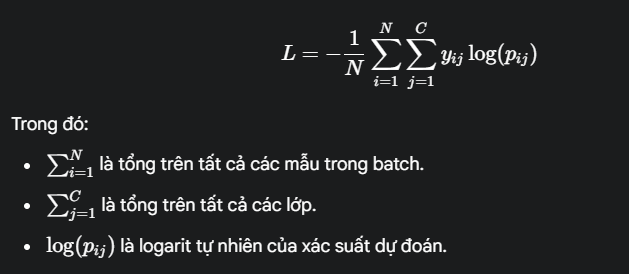

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D, TimeDistributed, LSTM, ConvLSTM2D, MaxPooling3D, MaxPooling2D, GlobalMaxPooling3D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(112, 112, 3))
for layer in base_model.layers:
    layer.trainable = False

input_shape = (10, 112, 112, 3)
input_layer = tf.keras.layers.Input(shape=input_shape)
time_distributed_features = TimeDistributed(base_model, name="10_densenet121")(input_layer)

conv_lstm = ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding='same',
    return_sequences=True,
    data_format='channels_last')(time_distributed_features)

time_distribute_GlobalPooling = TimeDistributed(GlobalMaxPooling2D())(conv_lstm)
flatten = Flatten()(time_distribute_GlobalPooling)
dense = Dense(1024, activation='tanh')(flatten)
output_layer = Dense(4, activation='softmax')(dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 10, 112, 112,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 10_densenet121                  │ (None, 10, 3, 3, 1024) │     7,037,504 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 10, 3, 3, 64)   │     2,507,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,204,996 (38.93 MB)

 Trainable params: 3,167,492 (12.08 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def train_model(model, train_data, train_labels, val_data, val_labels, epochs=20, batch_size=32):

    # Thiết lập callbacks để lưu lại mô hình tốt nhất và dừng sớm nếu không cải thiện
    checkpoint = ModelCheckpoint('/content/drive/MyDrive/SUBJECTS IUH/NHAN DANG MAU/checkpoint_classification_videos/model_Hai_re-new/model_convlstm.weights.h5', monitor='val_loss', save_best_only=True, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

    # Huấn luyện mô hình
    history = model.fit(
        train_data,
        train_labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(val_data, val_labels),
        callbacks=[checkpoint, early_stopping]
    )

    return history


## Lịch sử huấn luyện

In [ ]:
batch_size = 32

# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# train_dataset = train_dataset.cache().shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
# val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Gọi hàm huấn luyện
history = train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=batch_size)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 0.6185 - loss: 1.0793
Epoch 1: val_loss improved from inf to 0.24131, saving model to /content/drive/MyDrive/SUBJECTS IUH/NHAN DANG MAU/checkpoint_classification_videos/model_Hai_re-new/model_convlstm.weights.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.6206 - loss: 1.0732 - val_accuracy: 0.9455 - val_loss: 0.2413
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9661 - loss: 0.1064
Epoch 2: val_loss improved from 0.24131 to 0.08949, saving model to /content/drive/MyDrive/SUBJECTS IUH/NHAN DANG MAU/checkpoint_classification_videos/model_Hai_re-new/model_convlstm.weights.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 338ms/step - accuracy: 0.9661 - loss: 0.1063 - val_accuracy: 0.9758 - val_loss: 0.0895
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9713 - loss: 0.0706
Epoch 3: val_loss did not improve from 0.08949
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 318ms/step - accuracy: 0.9713 - loss: 0.0708 - val_accuracy: 0.8970 - val_loss: 0.3916
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9598 - loss: 0.1282
Epoch 4: val_loss improved from 0.08949 to 0.06673, saving model to /content/drive/MyDrive/SUBJECTS IUH/NHAN DANG MAU/checkpoint_classification_videos/model_Hai_re-new/model_convlstm.weights.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 334ms/step - accuracy: 0.9597 - loss: 0.1282 - val_accuracy: 0.9788 - val_loss: 0.0667
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9859 - loss: 0.0507
Epoch 5: val_loss did not improve from 0.06673
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 314ms/step - accuracy: 0.9859 - loss: 0.0507 - val_accuracy: 0.9697 - val_loss: 0.0959
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9791 - loss: 0.0618
Epoch 6: val_loss improved from 0.06673 to 0.02005, saving model to /content/drive/MyDrive/SUBJECTS IUH/NHAN DANG MAU/checkpoint_classification_videos/model_Hai_re-new/model_convlstm.weights.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 335ms/step - accuracy: 0.9791 - loss: 0.0617 - val_accuracy: 0.9939 - val_loss: 0.0200
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9888 - loss: 0.0325
Epoch 7: val_loss did not improve from 0.02005
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 316ms/step - accuracy: 0.9888 - loss: 0.0325 - val_accuracy: 0.9879 - val_loss: 0.0364
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9940 - loss: 0.0195
Epoch 8: val_loss did not improve from 0.02005
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 315ms/step - accuracy: 0.9939 - loss: 0.0197 - val_accuracy: 0.9848 - val_loss: 0.0277
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9906 - loss: 0.0233
Epoch 9: val_loss did not improve from 0.02005
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 315ms/step - accuracy: 0.9906 - loss: 0.0233 - val_accuracy: 0.9879 - val_loss: 0.0452
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9904 - loss: 0.0313
Epoch 10: val_loss improved from 0.02005 t

83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 335ms/step - accuracy: 0.9904 - loss: 0.0312 - val_accuracy: 0.9970 - val_loss: 0.0144
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9942 - loss: 0.0179
Epoch 11: val_loss did not improve from 0.01443
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 316ms/step - accuracy: 0.9942 - loss: 0.0180 - val_accuracy: 0.9909 - val_loss: 0.0182
Epoch 12/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9878 - loss: 0.0270
Epoch 12: val_loss improved from 0.01443 to 0.01394, saving model to /content/drive/MyDrive/SUBJECTS IUH/NHAN DANG MAU/checkpoint_classification_videos/model_Hai_re-new/model_convlstm.weights.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 29s 352ms/step - accuracy: 0.9879 - loss: 0.0270 - val_accuracy: 0.9970 - val_loss: 0.0139
Epoch 13/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9917 - loss: 0.0230
Epoch 13: val_loss did not improve from 0.01394
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 315ms/step - accuracy: 0.9917 - loss: 0.0230 - val_accuracy: 0.9879 - val_loss: 0.0431
Epoch 14/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9950 - loss: 0.0160
Epoch 14: val_loss did not improve from 0.01394
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 315ms/step - accuracy: 0.9950 - loss: 0.0161 - val_accuracy: 0.9939 - val_loss: 0.0156
Epoch 15/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9928 - loss: 0.0218
Epoch 15: val_loss improved from 0.01394 to 0.01100, saving model to /content/drive/MyDrive/SUBJECTS IUH/NHAN DANG MAU/checkpoint_classification_videos/model_Hai_re-new/model_convlstm.weights.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 334ms/step - accuracy: 0.9927 - loss: 0.0218 - val_accuracy: 0.9970 - val_loss: 0.0110
Epoch 16/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9914 - loss: 0.0211
Epoch 16: val_loss did not improve from 0.01100
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 315ms/step - accuracy: 0.9914 - loss: 0.0211 - val_accuracy: 0.9879 - val_loss: 0.0171
Epoch 17/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9924 - loss: 0.0195
Epoch 17: val_loss did not improve from 0.01100
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 316ms/step - accuracy: 0.9924 - loss: 0.0194 - val_accuracy: 0.9879 - val_loss: 0.0216
Epoch 18/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9920 - loss: 0.0190
Epoch 18: val_loss did not improve from 0.01100
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 315ms/step - accuracy: 0.9919 - loss: 0.0191 - val_accuracy: 0.9939 - val_loss: 0.0170
Epoch 19/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9916 - loss: 0.0205
Epoch 19: val_loss did not improve f

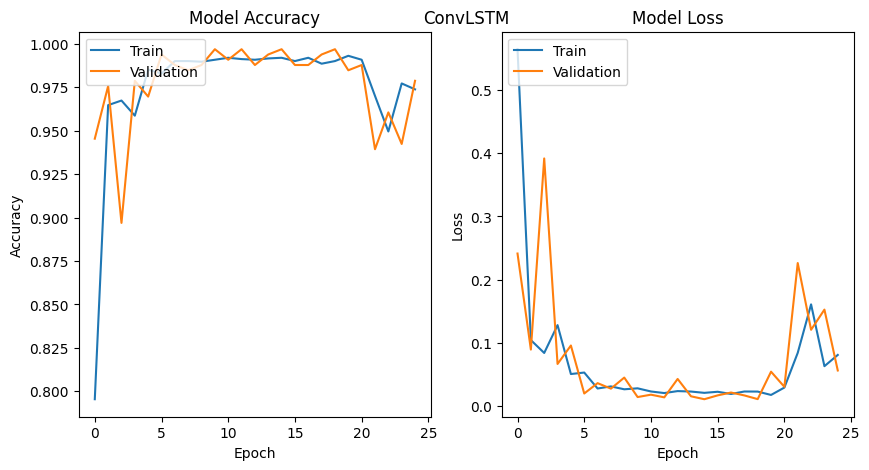

In [ ]:
import matplotlib.pyplot as plt
# 75.52
def plot_history(history):

  plt.figure(figsize=(10, 5))
  plt.title('ConvLSTM')
  plt.axis(False)

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

plot_history(history)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def predict_on_dataset(model, X_test, y_test):
    y_pred = []
    for video in X_test:
        input_data = np.expand_dims(video[:10], axis=0)
        prediction = model.predict(input_data)
        predicted_class_index = np.argmax(prediction)
        y_pred.append(predicted_class_index)
    return np.array(y_pred)

y_pred = predict_on_dataset(model, X_test, y_test)
print("Prediction completed")

1/1 ━━━━━━━━━━━━━━━━━━━━ 74s 74s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━

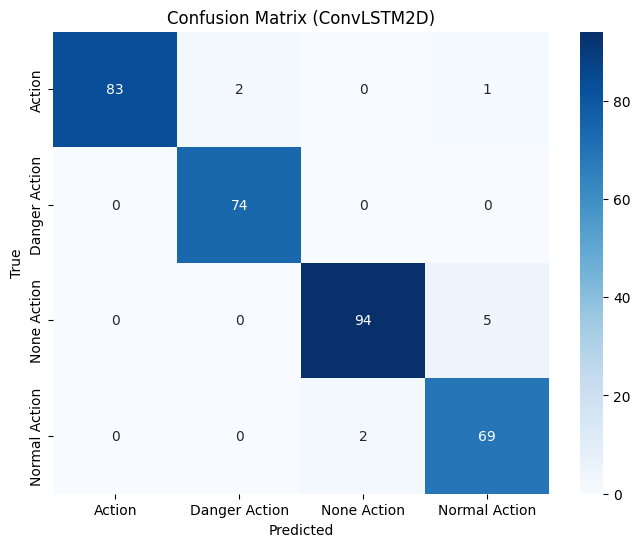

               precision    recall  f1-score   support

       Action       1.00      0.97      0.98        86
Danger Action       0.97      1.00      0.99        74
  None Action       0.98      0.95      0.96        99
Normal Action       0.92      0.97      0.95        71

     accuracy                           0.97       330
    macro avg       0.97      0.97      0.97       330
 weighted avg       0.97      0.97      0.97       330



In [ ]:
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Action', 'Danger Action', 'None Action', 'Normal Action'],
            yticklabels=['Action', 'Danger Action', 'None Action', 'Normal Action'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (ConvLSTM2D)')
plt.show()

from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=['Action', 'Danger Action', 'None Action', 'Normal Action']))

# PHẦN HẢI

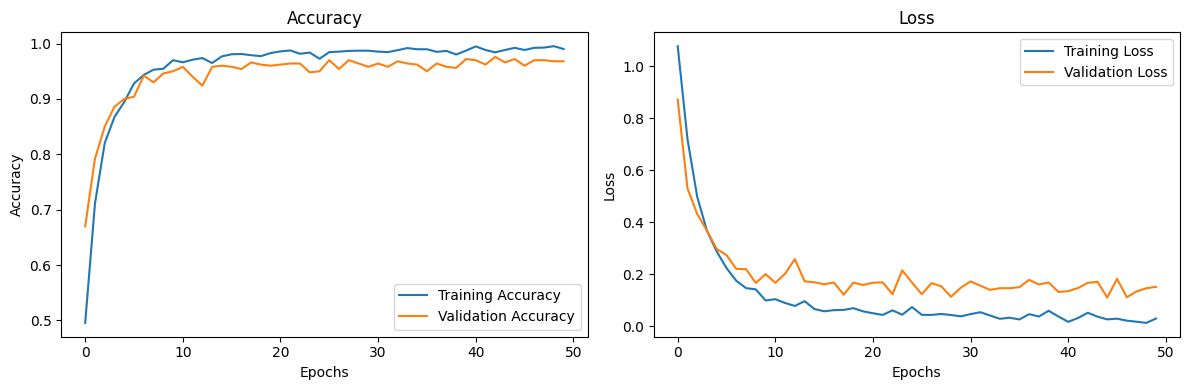

In [ ]:
# Vẽ đồ thị mất mát và độ chính xác
plt.figure(figsize=(12, 4))

# Đồ thị độ chính xác
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Đồ thị mất mát
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, recall_score

y_pred = model.predict(X_val_reshaped)
y_pred = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_val_reshaped, y_pred))


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step
F1-score per class: [0.968      0.98214286 0.97435897 0.94392523]
Recall per class: [0.968      0.97345133 0.98064516 0.94392523]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       125
           1       0.99      0.97      0.98       113
           2       0.97      0.98      0.97       155
           3       0.94      0.94      0.94       107

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500



## Confusion Matrix

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


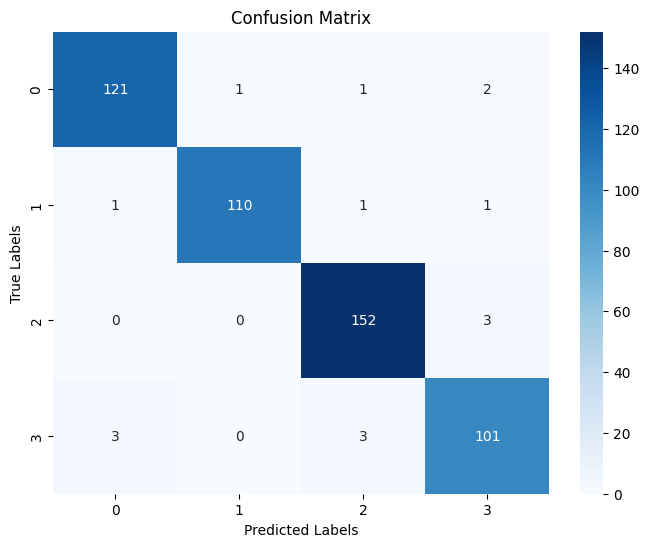

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = model.predict(X_val_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_val_reshaped, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val_reshaped), yticklabels=np.unique(y_val_reshaped))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
